# Initial Python Setup
First, we'll need to import the related libraries that will be used in this scirpt


In [1]:
import os
import pandas as pd
import requests as req
import numpy as np
import statsmodels.api as stapi
import statsmodels.formula.api as smf
import scipy.stats as st

from pandas import DataFrame
from zipfile import ZipFile
from io import BytesIO
from IPython.display import display
from matplotlib import rc as pltrc
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import RegressionResults, RegressionResultsWrapper

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Next, we'll set up some initial variables and configuration, such as links and display options


In [2]:
url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
file_name = 'survey_results_public.csv'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

pltrc('font', size=10)

# Importing the Dataset
Here, we will download and extract the dataset. We'll be doing the entire process in-memory, so you will not need to worry about any additional files being saved to your computer

In [3]:
response = req.get(url)
zip_file = ZipFile(BytesIO(response.content))
df = pd.read_csv(BytesIO(zip_file.read(file_name)))

Now, the dataframe is stored in the `df` variable, and looks like the following:

In [4]:
display(df)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.0,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trello,Slack;Zoom

# Data Cleaning
Now, the data won't work in the original state. As stated in the report, many of the variables are actually multi-selectable lists. The variables are stored as strings, using `;` as a separator.

We'll create new dataframes for each of these. In this step, we'll also need to rename some of the new columns to avoid including spaces or characters we can't use in regression.

In [5]:
df_languages = df["LanguageHaveWorkedWith"].str.get_dummies(';').rename(columns={
  "C#": "CSharp",
  "F#": "FSharp",
  "Bash/Shell": "Bash",
  "HTML/CSS": "HTML",
  "Objective-C": "ObjectiveC",
  "C++": "Cpp"
}).add_prefix("WorksIn_")

df_devtype = df["DevType"].str.get_dummies(";").rename(columns={
  "Academic researcher": "AcademicResearcher",
  "Cloud infrastructure engineer": "CloudInfrastructureEngineer",
  "Data or business analyst": "DataBusinessAnalyst",
  "Data scientist or machine learning specialist": "DataScientistMachineLearning",
  "Database administrator": "DatabaseAdministrator",
  "DevOps specialist": "DevOpsSpecialist",
  "Developer, QA or test": "DevQATest",
  "Developer, back-end": "DevBackend",
  "Developer, desktop or enterprise applications": "DevDesktopApps",
  "Developer, embedded applications or devices": "DevEmbedded",
  "Developer, front-end": "DevFrontend",
  "Developer, full-stack": "DevFullstack",
  "Developer, game or graphics": "DevGame",
  "Developer, mobile": "DevMobile",
  "Engineer, data": "DataEngineer",
  "Engineer, site reliability": "SiteReliabilityEngineer",
  "Engineering manager": "EngineerManager",
  "Marketing or sales professional": "MarketingSales",
  "Other (please specify):": "Other",
  "Product manager": "ProductManager",
  "Project manager":"ProjectManager",
  "Security professional": "Security",
  "Senior Executive (C-Suite, VP, etc.)": "SeniorExec",
  "System administrator": "SystemAdmin"
}).add_prefix("DevType_")
del df_devtype["DevType_Other"]

df_employment = df["Employment"].str.get_dummies(";").rename(columns={
  "Employed, full-time": "FullTime",
  "Employed, part-time": "PartTime",
  "I prefer not to say": "Unknown",
  "Independent contractor, freelancer, or self-employed": "SelfEmployed",
  "Not employed, and not looking for work": "UnemployedNotLooking",
  "Not employed, but looking for work": "UnemployedLooking",
  "Student, full-time": "StudentFullTime",
  "Student, part-time": "StudentPartTime"
}).add_prefix("Employed_")
del df_employment["Employed_Unknown"]

Each of these dataframes contain a column for every possible choice found in the dataset. For example, the `dummy_languages` contains each of the languages found in the dataset as follows:

In [6]:
display(df_languages)

,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_Cpp,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73263,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
73264,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
73265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
73266,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


If the person indicated that they have worked with the language, there will be a `1`. Otherwise, there will be a `0`.

Now, we can simply overwrite `df` to append these sub-dataframes into the main dataframe

In [7]:
df = pd.concat([df,df_languages, df_devtype, df_employment], axis = 1)

Next, some of the numeric columns have entries for extremities. For example, the `YearsCode` column can have the value `"Less than 1 year"` or `"More than 50 years"`, which can be problematic if we try to use them in our regression.

For simplification, we'll assume that `"Less than 1 year"` is `0`, and `"More than 50 years"` is `50`


In [8]:
df["NumYearsCode"] = pd.to_numeric(
  df["YearsCode"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

df["NumYearsCodePro"] = pd.to_numeric(
  df["YearsCodePro"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

Similarly, the text data for education level is bloated, so we will be replacing those in order to make our regression outputs cleaner

In [9]:
df["EducationLevel"] = df["EdLevel"].replace({
  "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "MastersDegree",
  "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "BachelorsDegree",
  "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "SecondarySchool",
  "Some college/university study without earning a degree": "SomeCollege",
  "Something else": "SomethingElse",
  "Primary/elementary school": "PrimarySchool",
  "Other doctoral degree (Ph.D., Ed.D., etc.)": "DoctoralDegree",
  "Associate degree (A.A., A.S., etc.)": "AssociatesDegree",
  "Professional degree (JD, MD, etc.)": "ProfessionalDegree"
})

# Filtering Data
Not all of the data can be useful to us. Entries come from across the world, get paid in different currencies, and not to mention some may put in false information. 

In order to get a dataset we can reliably use, we will first restrict our analysis on individuals in the United States. 

Next, we'll only use individuals who have the `"ConvertedCompYearly"` variable filled in. It appears that some of the outlier do not have this variable, so it may be StackOverflow's filtering to remove significant outliers

We will also remove any entries with any "unknown" values, such as having an unknown employment status

In [10]:
df_filtered = df[
  (df["Country"] == "United States of America") & 
  (df["ConvertedCompYearly"].notna())
]

Our data is now filtered properly, and ready to be analyzed

In [11]:
display(df_filtered)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_Cpp,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA,DevType_AcademicResearcher,DevType_Blockchain,DevType_CloudInfrastructureEngineer,DevType_DataBusinessAnalyst,DevType_DataScientistMachineLearning,DevType_DatabaseAdministrator,DevType_Designer,DevType_DevOpsSpecialist,DevType_DevQATest,DevType_DevBackend,DevType_DevDesktopApps,DevType_DevEmbedded,DevType_DevFrontend,DevType_DevFullstack,DevType_DevGame,DevType_DevMobile,DevType_Educator,DevType_DataEngineer,DevType_SiteReliabilityEngineer,DevType_EngineerManager,DevType_MarketingSales,DevType_ProductManager,DevType_ProjectManager,DevType_Scientist,DevType_Security,DevType_SeniorExec,DevType_Student,DevType_SystemAdmin,Employed_FullTime,Employed_PartTime,Employed_SelfEmployed,Employed_UnemployedNotLooking,Employed_UnemployedLooking,Employed_Retired,Employed_StudentFullTime,Employed_StudentPartTime,NumYearsCode,NumYearsCodePro,EducationLevel
11,12,"I am not primarily a developer, but I write co...","Employed, full-time;Independent contractor, fr...",Fully remote,Hobby;Contribute to open-source projects;Freel...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,NaN,12,10,Engineering manager,20 to 99 employees,I have some influence,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,194400.0,Yearly,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,C++;Go;HTML/CSS;JavaScript;Lua;Rust;TypeScript,Couchbase;CouchDB;Microsoft SQL Server;MongoDB...,Elasticsearch;MongoDB;Redis;SQLite,AWS;Microsoft Azure,AWS;DigitalOcean;Firebase;Linode,ASP.NET;ASP.NET Core ;Express;Node.js;Vue.js,ASP.NET Core ;Node.js;Nuxt.js;React.js;Vue.js,.NET;Keras;NumPy;Pandas;Scikit-learn;TensorFlo...,Keras;NumPy;Pandas;Scikit-learn;TensorFlow;Tor...,Docker;Homebrew;Kubernetes,Docker;Homebrew;Kubernetes;Pulumi;Terraform,IPython/Jupyter;Neovim;Visual Studio;Visual St...,IPython/Jupyter;Neovim;Visual Studio Code,Linux-based;macOS;Windows,Linux-based;macOS,Git,Code editor;Dedicated version control GUI appl...,NaN,NaN,Confluence;Jira Work Management;Notion;Trello,Notion;Trello,Cisco Webex Teams;Google Chat;Microsoft Teams;...,Slack,Unfavorable,Stack Ove

# Helper Functions

To make things easier, I'll create a bunch of functions here that help automate the displaying of plots (which can be copied into the report).



This function helps us by simply removing the first section of our new variables (so `WorksIn_Python` results in `Python`)


In [12]:
def removePrefix(string: str):
  return string[string.find('_')+1:]

This function will help visualize the effects of each column. By default, it will be set to show the languages, but it is configurable for my needs further on

In [13]:
def showCoefficientGraph(
    regression: RegressionResultsWrapper, 
    columns: list[str] = list(df_languages.columns),
    fig_size = (30,10),
    y_scale_factor = 1,
    ylabel="Coefficient",
    xlabel="Variable",
    remove_underscore = True,
    replace_underscore_with_space = True,
    font_size=20,
    title="Variable Coefficients",
    rotate_xticks = -90,
    show_stddev = False,
    show_grid = True,
    tick_scale = 10,
    scale = True
  ):



  reg: RegressionResults = regression #type: ignore
  table: pd.DataFrame = reg.summary2().tables[1]
  table = table[table.index.isin(columns)]
  if show_stddev:
    table["Coef."] = np.abs(table["Coef."] / table["Std.Err."])
  table = table.sort_values(by=["Coef."])
  
  
  if remove_underscore:
    table = table.set_axis([removePrefix(axis) for axis in list(table.index)], axis='index')
  elif replace_underscore_with_space:
    table = table.set_axis([axis.replace('_',' ') for axis in list(table.index)], axis='index')

  pltrc('font', size=font_size)
  plt.figure(figsize = fig_size)
  plt.xticks(rotation=rotate_xticks)
  barcontainer = plt.bar(table.index,table["Coef."] * y_scale_factor)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)

  values = table["Coef."] * y_scale_factor

  mn = (int(min(values)) // tick_scale) * tick_scale - tick_scale
  mx = (int(max(values)) // tick_scale) * tick_scale + tick_scale

  if scale:
    plt.yticks(np.arange(mn, mx+1, tick_scale))

  if title:
    plt.title(title)
  
  if show_grid:
    plt.grid(color='black', linestyle=':', linewidth=2, axis='y', alpha=0.7)

  if show_stddev:
    for a,color in [(0.90,'red'),(0.95,'green'),(0.99,'purple')]:
      plt.axhline(y = st.norm.interval(confidence=a)[1], label = f'{a * 100}% Confidence Interval', color=color)
    plt.legend(loc='upper left')

  return plt


Similarly, we'll need a function to display the summary (with additional features)

In [14]:
def display_summary(
    regression: RegressionResultsWrapper, 
    remove_underscore = True,
    replace_underscore_with_space = True,
  ):
  reg: RegressionResults = regression #type: ignore
  tables = reg.summary2().tables
  table: pd.DataFrame = tables[1]

  if remove_underscore:
    table = table.set_axis([removePrefix(axis) for axis in list(table.index)], axis='index')
  elif replace_underscore_with_space:
    table = table.set_axis([axis.replace('_',' ') for axis in list(table.index)], axis='index')

  return table
  

Additionally, we'll make a function that will export the table into a latex longtable

In [15]:
def to_longtable(
    table: pd.DataFrame,
    cols: list[str] = ["index", "Coef.", "Std.Err."],
    width: list[float] = [0.4,0.3,0.3],
  ):
  df: DataFrame = table

  if "index" in cols:
    df.reset_index(inplace=True)
    df["index"] = [removePrefix(item) for item in df["index"]]

  # df = df.set_axis([removePrefix(axis) for axis in list(df.index)], axis='index')
  

  columns = [table[col] for col in cols]

  bs = chr(92)
  nl = '\n'

  def format(item):
    if type(item) in [int, str, np.float64, np.float32, np.float16, np.int64, np.int32, np.int16]:
      return f'${item}$'
    else:
      return str(item)

  return (
f"""{bs}begin{{longtable}}{{|{'|'.join([f'R{{{d}{bs}linewidth}}' for d in width])}|}}
{bs}hline
{' & '.join([f'{bs}textbf{{{name if name != "index" else "Coefficient"}}}' for name in cols])} {bs}{bs}

{bs}hline
{f"{bs}{bs}{nl}{bs}hline{nl}".join([
  ' & '.join([format(col[i]) for col in columns])
  for i in range(len(columns[0]))
])} {bs}{bs}
{bs}hline
{bs}end{{longtable}}
"""
  )
  

We'll also need to be able to get the columns from the sub-dataframes

In [16]:
def cols(df: pd.DataFrame) -> list[str]:
  return list(df.columns)

And a way to join them into a `" + "` separated string

In [17]:
def add(vals: list[str]) -> str:
  return " + ".join(vals)

# Inspecting Data Distribution

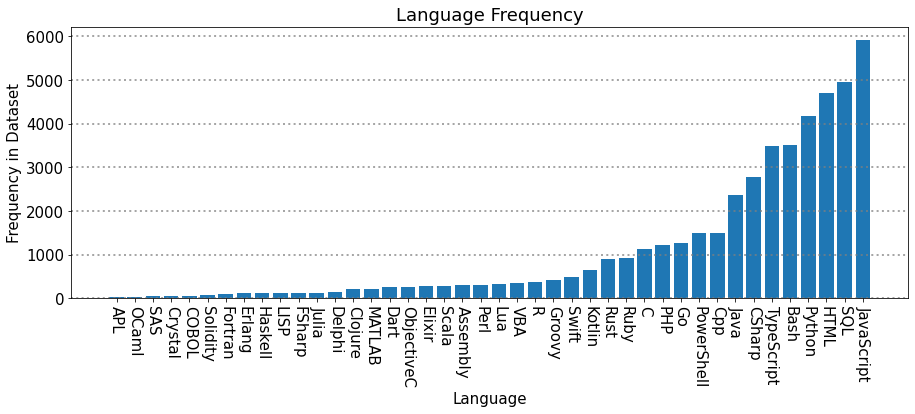

In [18]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_languages)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Language Frequency")
plt.xlabel("Language")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

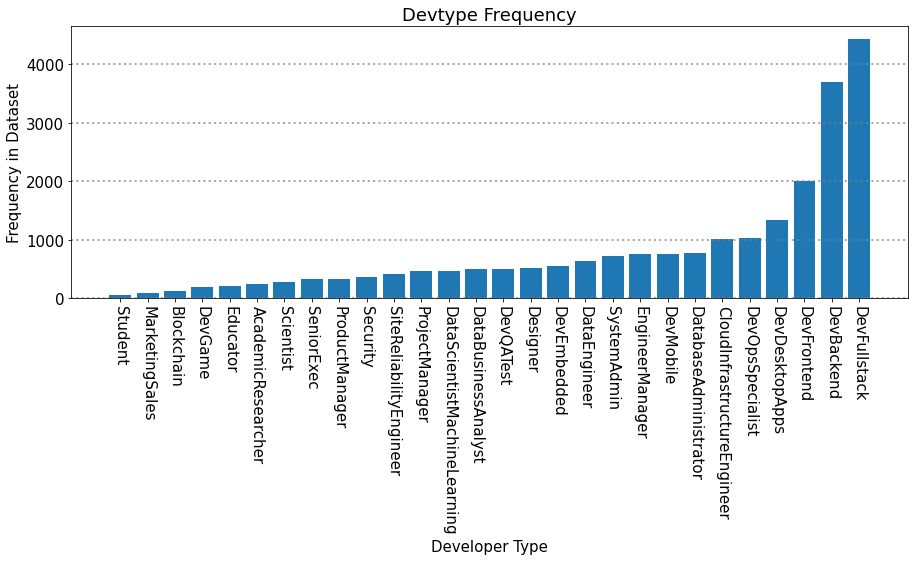

In [19]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_devtype)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Devtype Frequency")
plt.xlabel("Developer Type")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

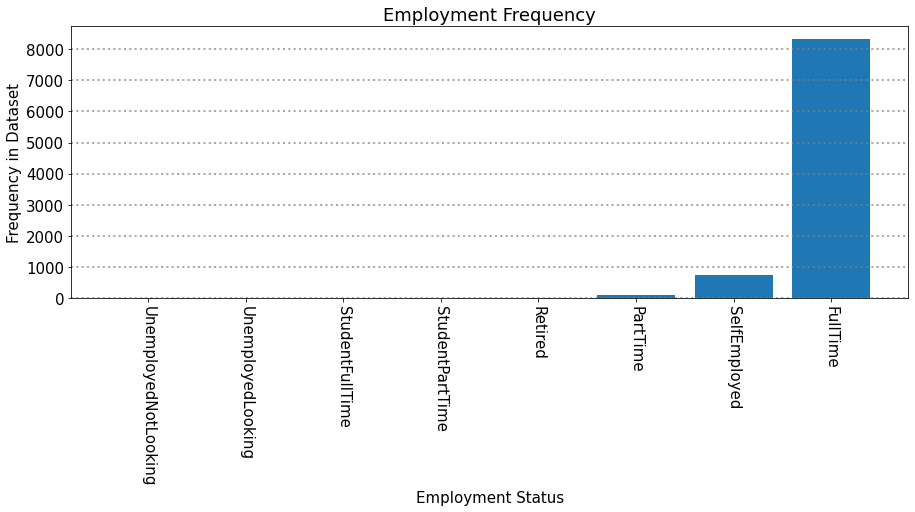

In [20]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_employment)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Employment Frequency")
plt.xlabel("Employment Status")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

# Analysis
Now, we get into the fun part. I won't have much of the explanation here, since that's the purpose of the report. However, I'll try to include a basic idea of what each part is


In [21]:
model_1 = ols(f"np.log(ConvertedCompYearly) ~ {add(cols(df_languages))}", data = df_filtered).fit()

In [22]:
print(to_longtable(model_1.summary2().tables[1]))

\begin{longtable}{|R{0.4\linewidth}|R{0.3\linewidth}|R{0.3\linewidth}|}
\hline
\textbf{Coefficient} & \textbf{Coef.} & \textbf{Std.Err.} \\

\hline
$Intercept$ & $11.984827291479098$ & $0.02638387358022838$\\
\hline
$APL$ & $-0.3515753166379167$ & $0.19040656218496493$\\
\hline
$Assembly$ & $-0.022774878270092502$ & $0.06417391271084091$\\
\hline
$Bash$ & $0.09741574494862054$ & $0.023518192003779363$\\
\hline
$C$ & $-0.01408012372624834$ & $0.03917209398994089$\\
\hline
$CSharp$ & $-0.00021813880139623376$ & $0.026260139810175182$\\
\hline
$Cpp$ & $0.01614481188137749$ & $0.033374008097449$\\
\hline
$COBOL$ & $-0.012468453361355524$ & $0.13124773008888396$\\
\hline
$Clojure$ & $0.08834989390983414$ & $0.06871291266628012$\\
\hline
$Crystal$ & $-0.29154156186226693$ & $0.13534770428054974$\\
\hline
$Dart$ & $-0.08507639914970087$ & $0.06313528331030023$\\
\hline
$Delphi$ & $0.10668317960652333$ & $0.08268988890859226$\\
\hline
$Elixir$ & $0.08169166663537582$ & $0.06883555200202428$\\


In [23]:
model_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:              OLS                         Adj. R-squared:     0.024     
Dependent Variable: np.log(ConvertedCompYearly) AIC:                24453.1840
Date:               2022-12-17 17:41            BIC:                24757.2749
No. Observations:   8707                        Log-Likelihood:     -12184.   
Df Model:           42                          F-statistic:        6.000     
Df Residuals:       8664                        Prob (F-statistic): 3.38e-31  
R-squared:          0.028                       Scale:              0.96623   
--------------------------------------------------------------------------------
                       Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------------------
Intercept             11.9848     0.0264   454.2482   0.0000   11.9331   12.0365
WorksIn_APL           -0.3516     0.1904    -1.8464   0.0649   -0.7248    0.0217
WorksIn_Assembly      -0.0228     0.0642    -0.3549   0.7227   -0.1486    0.1030
WorksIn_Bash           0.0974     0.0235     4.1421   0.0000    0.0513    0.1435
WorksIn_C             -0.0141     0.0392    -0.3594   0.7193   -0.0909    0.0627
WorksIn_CSharp        -0.0002     0.0263    -0.0083   0.9934   -0.0517    0.0513
WorksIn_Cpp            0.0161     0.0334     0.4838   0.6286   -0.0493    0.0816
WorksIn_COBOL         -0.0125     0.1312    -0.0950   0.9243   -0.2697    0.2448
WorksIn_Clojure        0.0883     0.0687     1.2858   0.1986   -0.0463    0.2230
WorksIn_Crystal       -0.2915     0.1353    -2.1540   0.0313   -0.5569   -0.0262
WorksIn_Dart          -0.0851     0.0631    -1.3475   0.1778   -0.2088    0.0387
WorksIn_Delphi         0.1067     0.0827     1.2902   0.1970   -0.0554    0.2688
WorksIn_Elixir         0.0817     0.0688     1.1868   0.2354   -0.0532    0.2166
WorksIn_Erlang         0.0050     0.1067     0.0466   0.9628   -0.2041    0.2141
WorksIn_FSharp         0.0645     0.0871     0.7408   0.4589   -0.1063    0.2353
WorksIn_Fortran       -0.1383     0.1025    -1.3492   0.1773   -0.3393    0.0626
WorksIn_Go             0.1332     0.0316     4.2183   0.0000    0.0713    0.1951
WorksIn_Groovy         0.1232     0.0511     2.4105   0.0160    0.0230    0.2233
WorksIn_HTML          -0.1682     0.0261    -6.4341   0.0000   -0.2195   -0.1170
WorksIn_Haskell       -0.0208     0.0919    -0.2257   0.8214   -0.2009    0.1594
WorksIn_Java           0.0483     0.0258     1.8707   0.0614   -0.0023    0.0989
WorksIn_JavaScript    -0.0392     0.0292    -1.3424   0.1795   -0.0965    0.0180
WorksIn_Julia         -0.1224     0.0895    -1.3674   0.1715   -0.2979    0.0531
WorksIn_Kotlin         0.0034     0.0429     0.0792   0.9369   -0.0807    0.0875
WorksIn_LISP           0.0676     0.0936     0.7222   0.4702   -0.1159    0.2511
WorksIn_Lua           -0.0553     0.0565    -0.9782   0.3280   -0.1660    0.0555
WorksIn_MATLAB        -0.0806     0.0694    -1.1622   0.2452   -0.2166    0.0554
WorksIn_OCaml         -0.1543     0.1763    -0.8752   0.3815   -0.4998    0.1913
WorksIn_ObjectiveC     0.1438     0.0703     2.0453   0.0409    0.0060    0.2816
WorksIn_PHP           -0.1425     0.0318    -4.4876   0.0000   -0.2048   -0.0803
WorksIn_Perl           0.0558     0.0588     0.9485   0.3429   -0.0595    0.1710
WorksIn_PowerShell    -0.0287     0.0309    -0.9294   0.3527   -0.0893    0.0319
WorksIn_Python         0.0003     0.0231     0.0113   0.9910   -0.0449    0.0454
WorksIn_R             -0.0733     0.0546    -1.3421   0.1796   -0.1804    0.0338
WorksIn_Ruby           0.0992     0.0353     2.8134   0.0049    0.0301    0.1683
WorksIn_Rust           0.0585     0.0370     1.5790   0.1144   -0.0141    0.1311
WorksIn_SAS           -0.0599     0.1391    -0.4303   0.6670   -0.3326    0.2128
WorksIn_SQL            0

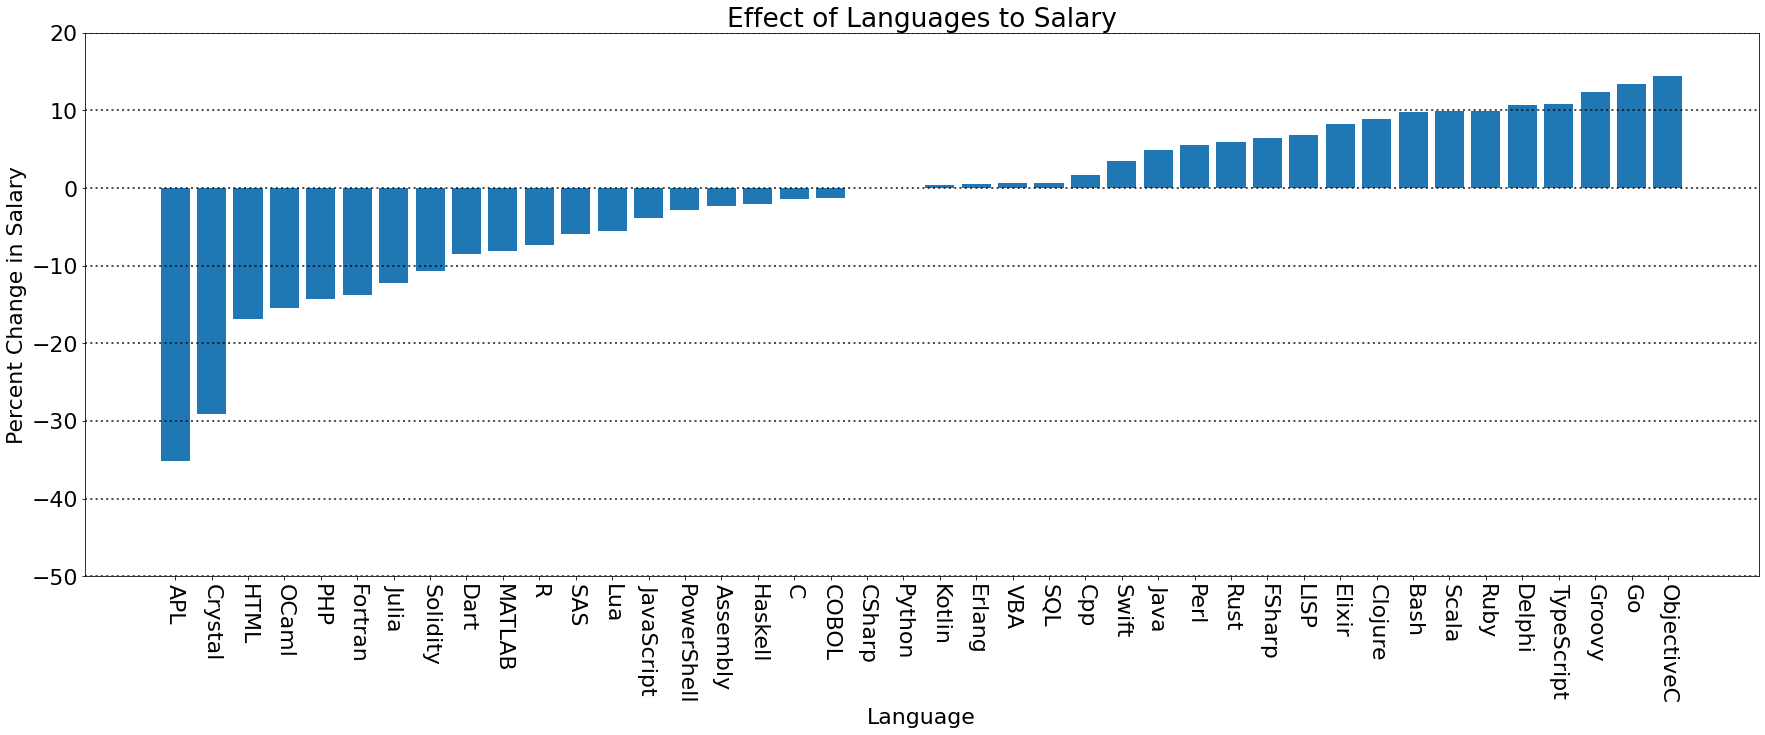

In [24]:
showCoefficientGraph(
  model_1,
  columns = cols(df_languages),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Languages to Salary",
  xlabel="Language",
  ylabel="Percent Change in Salary"
).show()

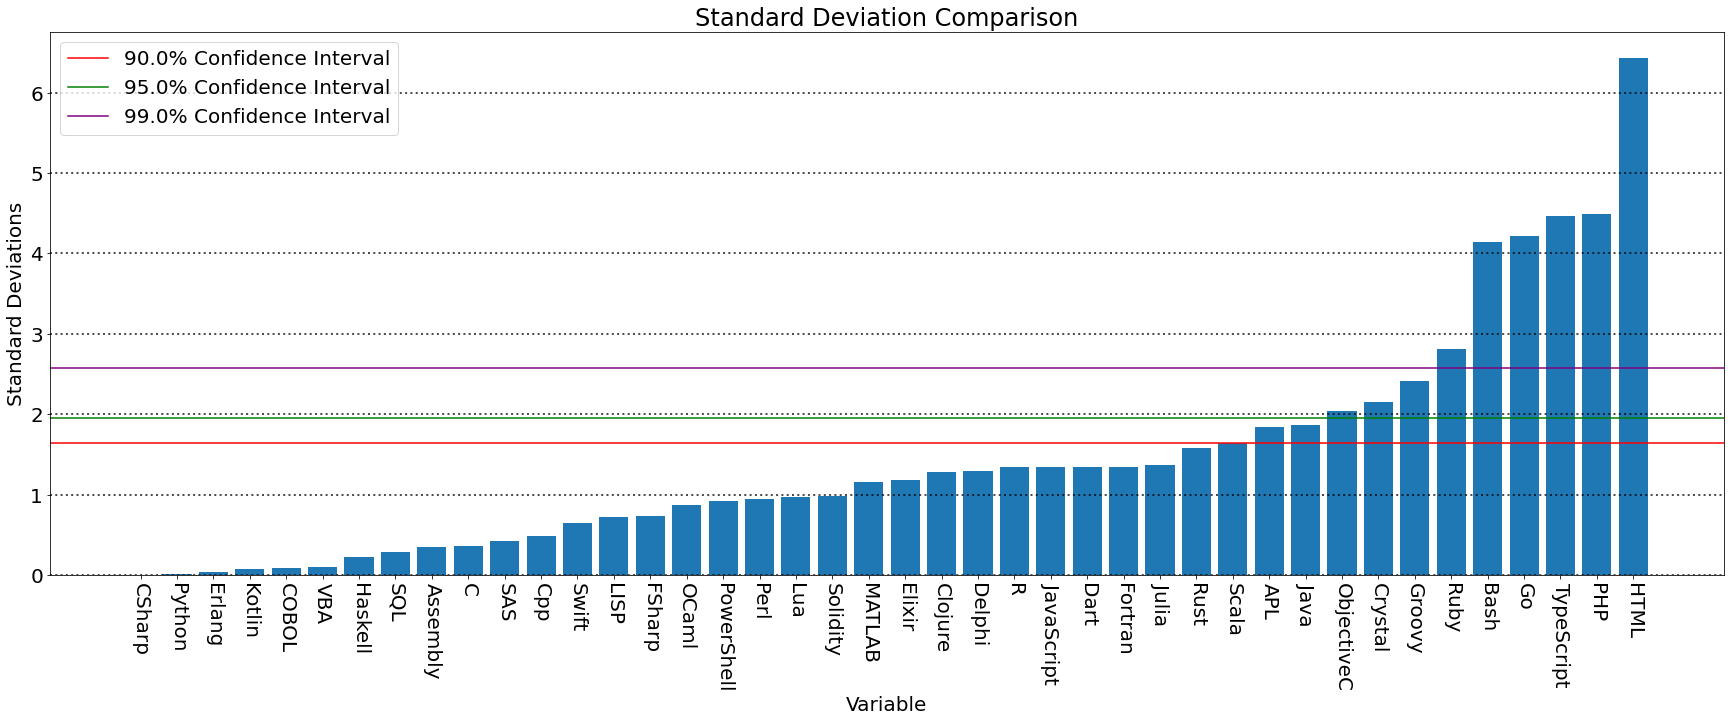

In [25]:
showCoefficientGraph(
  model_1,
  columns = cols(df_languages),
  scale=False,
  show_stddev=True,
  title="Standard Deviation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()

In [26]:
model_2 = ols(f"np.log(ConvertedCompYearly) ~ {add(cols(df_languages) + cols(df_devtype))}", data = df_filtered).fit()

In [27]:
print(to_longtable(model_2.summary2().tables[1]))

\begin{longtable}{|R{0.4\linewidth}|R{0.3\linewidth}|R{0.3\linewidth}|}
\hline
\textbf{Coefficient} & \textbf{Coef.} & \textbf{Std.Err.} \\

\hline
$Intercept$ & $11.942441579866246$ & $0.028446657909423873$\\
\hline
$APL$ & $-0.3402418044472495$ & $0.19012995517157452$\\
\hline
$Assembly$ & $-0.023320763962329728$ & $0.06419663909982101$\\
\hline
$Bash$ & $0.08079429577687229$ & $0.023744318938909124$\\
\hline
$C$ & $0.00976761423446626$ & $0.039822132484480424$\\
\hline
$CSharp$ & $-0.009187320233586637$ & $0.026590883866044107$\\
\hline
$Cpp$ & $0.03146066762066721$ & $0.03397882453422706$\\
\hline
$COBOL$ & $0.005052915141925268$ & $0.1303804244758583$\\
\hline
$Clojure$ & $0.06141229208950624$ & $0.06830282672385413$\\
\hline
$Crystal$ & $-0.2581833523335814$ & $0.13467915987774168$\\
\hline
$Dart$ & $-0.07912065451075$ & $0.06343234883157134$\\
\hline
$Delphi$ & $0.1384251976051225$ & $0.08369666792093462$\\
\hline
$Elixir$ & $0.04181373236990327$ & $0.06846089100086604$\\
\hline

In [28]:
model_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                 OLS                           Adj. R-squared:       0.040     
Dependent Variable:    np.log(ConvertedCompYearly)   AIC:                  24333.6982
Date:                  2022-12-17 17:41              BIC:                  24835.8018
No. Observations:      8707                          Log-Likelihood:       -12096.   
Df Model:              70                            F-statistic:          6.173     
Df Residuals:          8636                          Prob (F-statistic):   5.73e-52  
R-squared:             0.048                         Scale:                0.95002   
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Intercept                            11.9424   0.0284 419.8188 0.0000 11.8867 11.9982
WorksIn_APL                          -0.3402   0.1901  -1.7895 0.0736 -0.7129  0.0325
WorksIn_Assembly                     -0.0233   0.0642  -0.3633 0.7164 -0.1492  0.1025
WorksIn_Bash                          0.0808   0.0237   3.4027 0.0007  0.0342  0.1273
WorksIn_C                             0.0098   0.0398   0.2453 0.8062 -0.0683  0.0878
WorksIn_CSharp                       -0.0092   0.0266  -0.3455 0.7297 -0.0613  0.0429
WorksIn_Cpp                           0.0315   0.0340   0.9259 0.3545 -0.0351  0.0981
WorksIn_COBOL                         0.0051   0.1304   0.0388 0.9691 -0.2505  0.2606
WorksIn_Clojure                       0.0614   0.0683   0.8991 0.3686 -0.0725  0.1953
WorksIn_Crystal                      -0.2582   0.1347  -1.9170 0.0553 -0.5222  0.0058
WorksIn_Dart                         -0.0791   0.0634  -1.2473 0.2123 -0.2035  0.0452
WorksIn_Delphi                        0.1384   0.0837   1.6539 0.0982 -0.0256  0.3025
WorksIn_Elixir                        0.0418   0.0685   0.6108 0.5414 -0.0924  0.1760
WorksIn_Erlang                        0.0047   0.1063   0.0438 0.9650 -0.2037  0.2130
WorksIn_FSharp                        0.0489   0.0865   0.5649 0.5722 -0.1208  0.2185
WorksIn_Fortran                      -0.0896   0.1035  -0.8658 0.3866 -0.2926  0.1133
WorksIn_Go                            0.0814   0.0321   2.5379 0.0112  0.0185  0.1443
WorksIn_Groovy                        0.1049   0.0510   2.0567 0.0397  0.0049  0.2050
WorksIn_HTML                         -0.1437   0.0265  -5.4172 0.0000 -0.1957 -0.0917
WorksIn_Haskell                       0.0044   0.0914   0.0486 0.9612 -0.1748  0.1837
WorksIn_Java                          0.0405   0.0259   1.5598 0.1188 -0.0104  0.0913
WorksIn_JavaScript                   -0.0398   0.0298  -1.3329 0.1826 -0.0983  0.0187
WorksIn_Julia                        -0.0973   0.0902  -1.0795 0.2804 -0.2741  0.0794
WorksIn_Kotlin                        0.0051   0.0432   0.1181 0.9060 -0.0796  0.0898
WorksIn_LISP                          0.0598   0.0933   0.6405 0.5218 -0.1231  0.2426
WorksIn_Lua                          -0.0506   0.0562  -0.9007 0.3678 -0.1608  0.0596
WorksIn_MATLAB                       -0.0370   0.0697  -0.5308 0.5955 -0.1737  0.0997
WorksIn_OCaml                        -0.0998   0.1754  -0.5691 0.5693 -0.4438  0.2441
WorksIn_ObjectiveC                    0.1576   0.0707   2.2302 0.0258  0.0191  0.2962
WorksIn_PHP                          -0.1244   0.0319  -3.8971 0.0001 -0.1870 -0.0619
WorksIn_Perl                          0.0661   0.0586   1.1280 0.2594 -0.0488  0.1809
WorksIn_PowerShell                   -0.0125   0.0311  -0.4007 0.6887 -0.0734  0.0485
WorksIn_Python                       -0.0076   0.0235  -0.3248 0.7454 -0.0536  0.0384
WorksIn_R                            -0.0604   0.0572  -1.0560 0.2910 -0.1725  0.0517
WorksIn_Ruby          

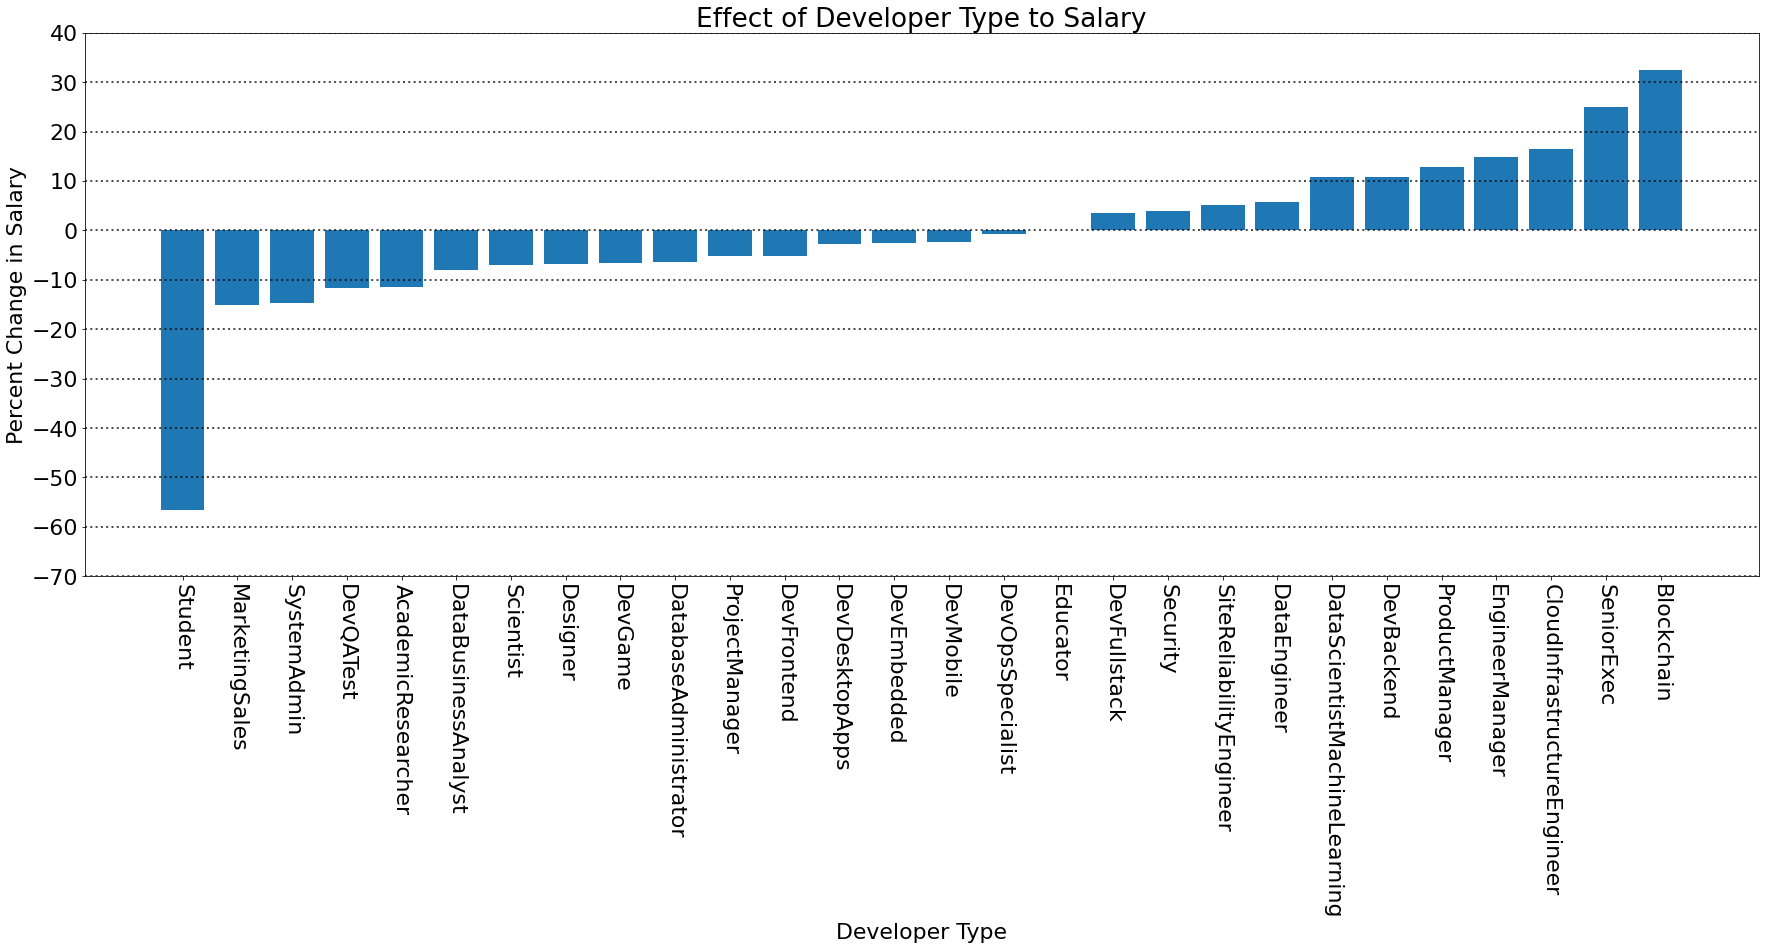

In [29]:
showCoefficientGraph(
  model_2,
  columns = cols(df_devtype),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Developer Type to Salary",
  xlabel="Developer Type",
  ylabel="Percent Change in Salary"
).show()

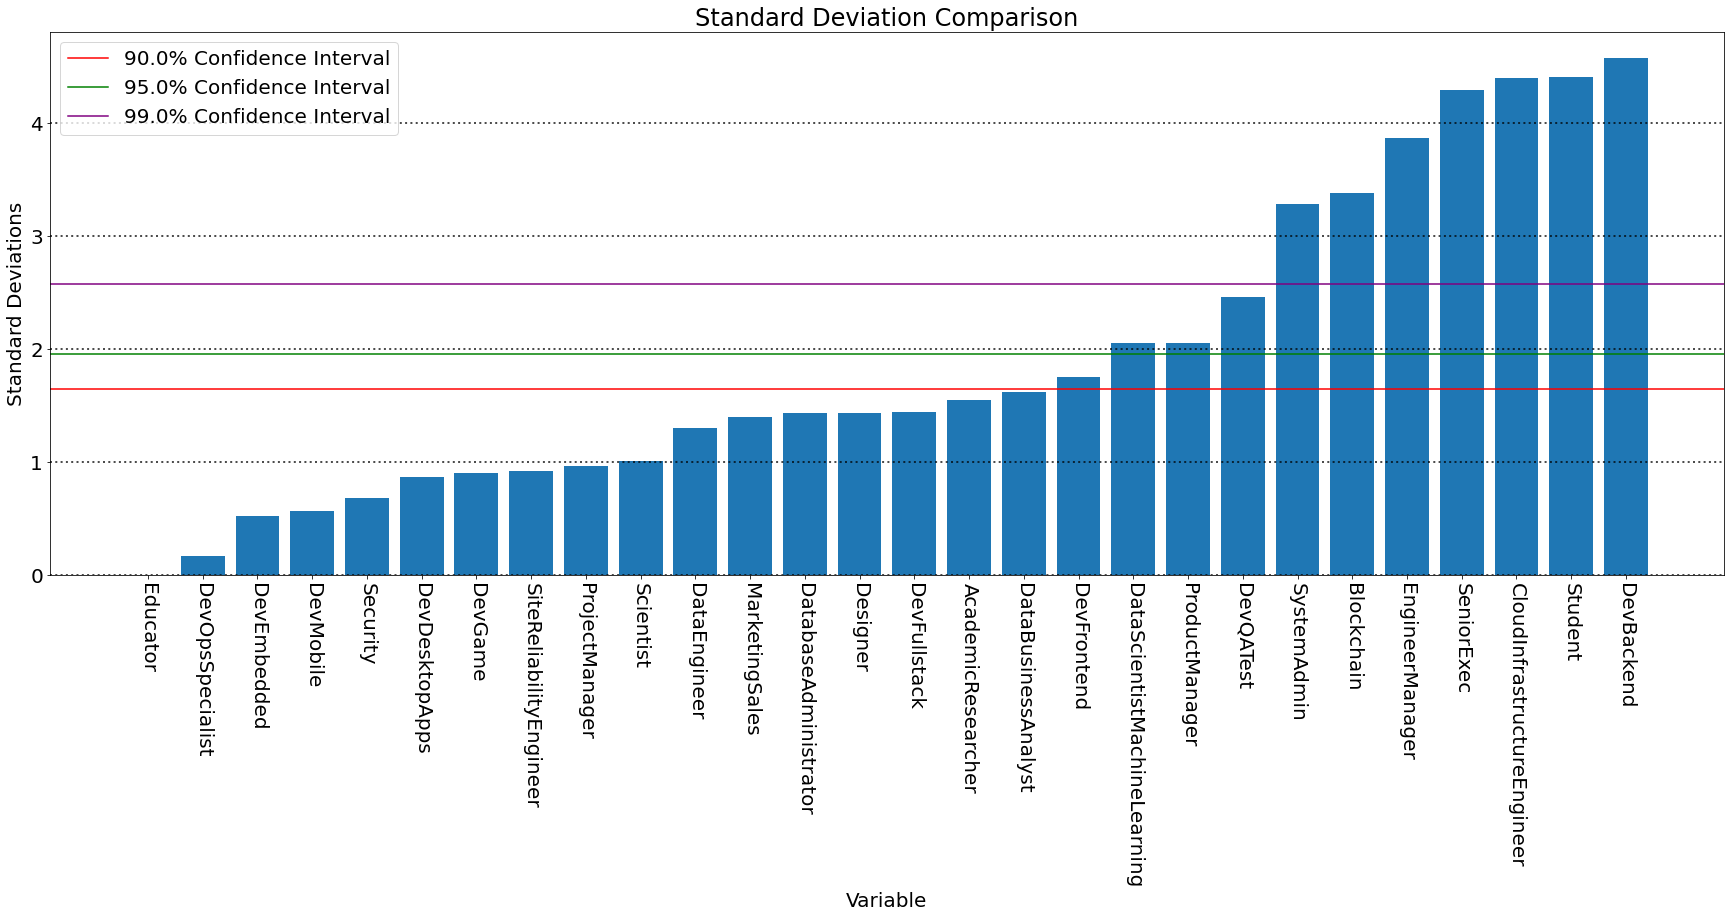

In [30]:
showCoefficientGraph(
  model_2,
  columns = cols(df_devtype),
  scale=False,
  show_stddev=True,
  title="Standard Deviation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()

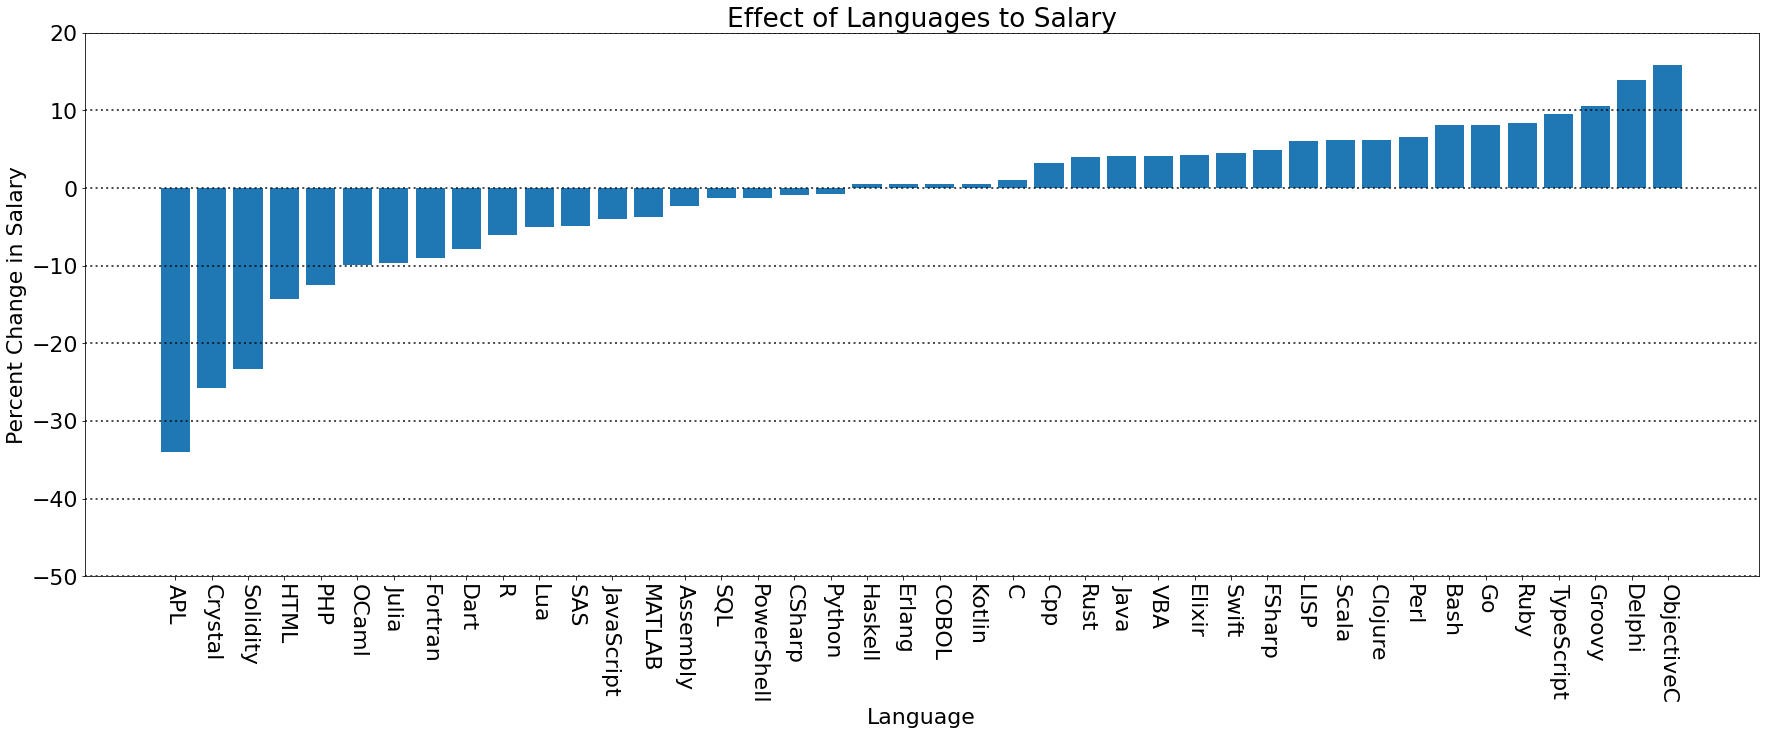

In [31]:
showCoefficientGraph(
  model_2,
  columns = cols(df_languages),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Languages to Salary",
  xlabel="Language",
  ylabel="Percent Change in Salary"
).show()

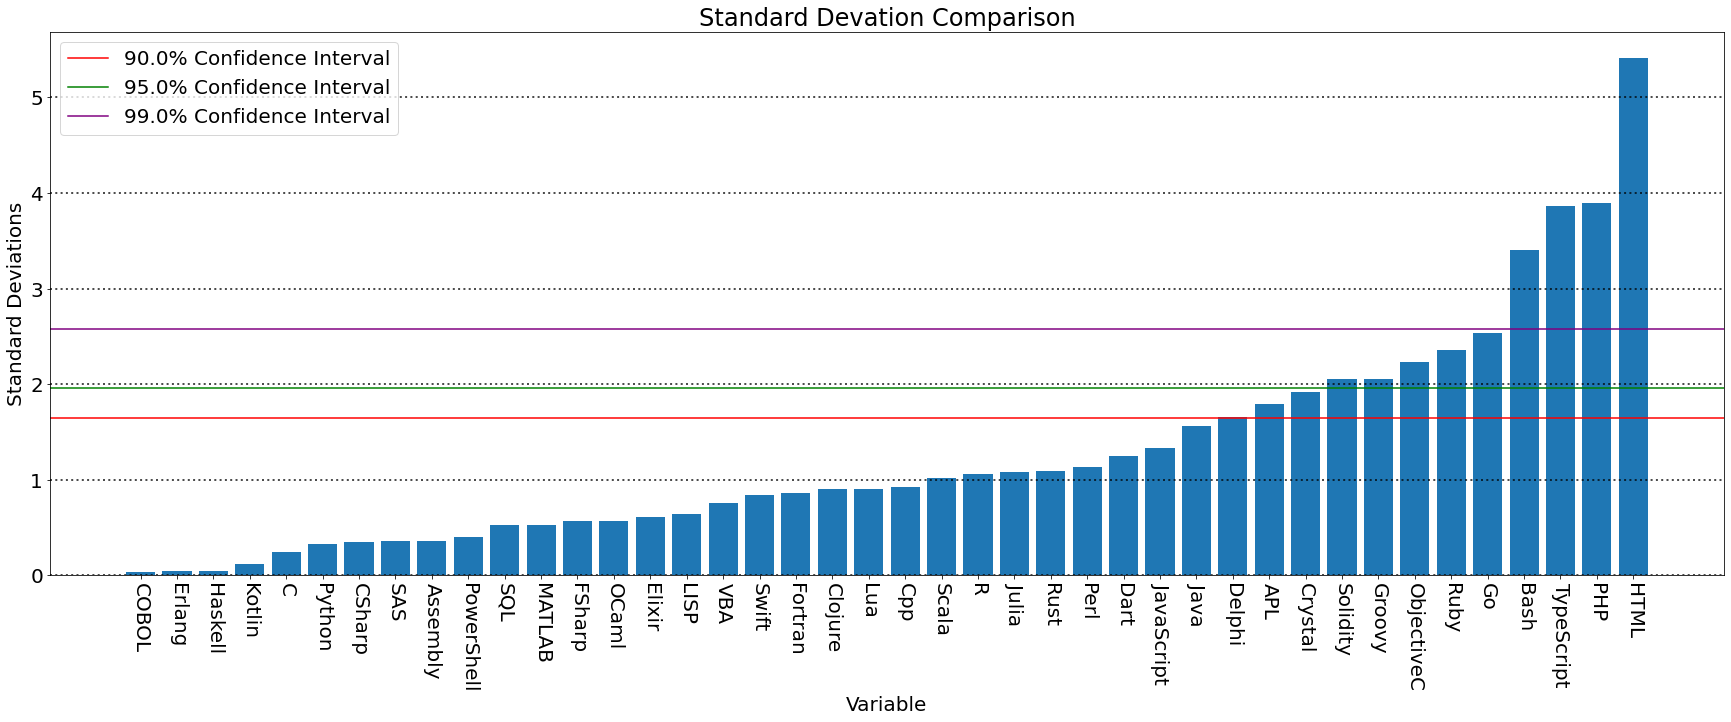

In [32]:
showCoefficientGraph(
  model_2,
  columns = cols(df_languages),
  scale=False,
  show_stddev=True,
  title="Standard Devation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()

In [33]:
model_3 = ols(f"np.log(ConvertedCompYearly) ~ {add(cols(df_languages) + cols(df_devtype) + ['Employed_FullTime', 'Employed_PartTime', 'NumYearsCodePro'])}", data = df_filtered).fit()

In [34]:
print(to_longtable(model_3.summary2().tables[1]))

\begin{longtable}{|R{0.4\linewidth}|R{0.3\linewidth}|R{0.3\linewidth}|}
\hline
\textbf{Coefficient} & \textbf{Coef.} & \textbf{Std.Err.} \\

\hline
$Intercept$ & $11.558104139865474$ & $0.06359592918251283$\\
\hline
$APL$ & $-0.3381757301438681$ & $0.18889615389830544$\\
\hline
$Assembly$ & $-0.018080404406961695$ & $0.06382542036227189$\\
\hline
$Bash$ & $0.06762485653402327$ & $0.02360918273993907$\\
\hline
$C$ & $-0.002705393068643265$ & $0.03964603398712886$\\
\hline
$CSharp$ & $-0.027869664385359122$ & $0.026451256005736033$\\
\hline
$Cpp$ & $0.027862369904000824$ & $0.03374056532239126$\\
\hline
$COBOL$ & $-0.024086370496504195$ & $0.13044447514572283$\\
\hline
$Clojure$ & $0.03839103922264975$ & $0.06812195737248733$\\
\hline
$Crystal$ & $-0.2725604831143382$ & $0.13362044916356283$\\
\hline
$Dart$ & $-0.06657890689657456$ & $0.06315631188515229$\\
\hline
$Delphi$ & $0.026211539612785162$ & $0.08425682819795559$\\
\hline
$Elixir$ & $0.03452259826539689$ & $0.06792914007718416$\\

In [35]:
model_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                 OLS                           Adj. R-squared:       0.057     
Dependent Variable:    np.log(ConvertedCompYearly)   AIC:                  24131.1984
Date:                  2022-12-17 17:41              BIC:                  24654.3220
No. Observations:      8684                          Log-Likelihood:       -11992.   
Df Model:              73                            F-statistic:          8.191     
Df Residuals:          8610                          Prob (F-statistic):   4.49e-80  
R-squared:             0.065                         Scale:                0.93468   
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Intercept                            11.5581   0.0636 181.7428 0.0000 11.4334 11.6828
WorksIn_APL                          -0.3382   0.1889  -1.7903 0.0734 -0.7085  0.0321
WorksIn_Assembly                     -0.0181   0.0638  -0.2833 0.7770 -0.1432  0.1070
WorksIn_Bash                          0.0676   0.0236   2.8643 0.0042  0.0213  0.1139
WorksIn_C                            -0.0027   0.0396  -0.0682 0.9456 -0.0804  0.0750
WorksIn_CSharp                       -0.0279   0.0265  -1.0536 0.2921 -0.0797  0.0240
WorksIn_Cpp                           0.0279   0.0337   0.8258 0.4090 -0.0383  0.0940
WorksIn_COBOL                        -0.0241   0.1304  -0.1846 0.8535 -0.2798  0.2316
WorksIn_Clojure                       0.0384   0.0681   0.5636 0.5731 -0.0951  0.1719
WorksIn_Crystal                      -0.2726   0.1336  -2.0398 0.0414 -0.5345 -0.0106
WorksIn_Dart                         -0.0666   0.0632  -1.0542 0.2918 -0.1904  0.0572
WorksIn_Delphi                        0.0262   0.0843   0.3111 0.7557 -0.1390  0.1914
WorksIn_Elixir                        0.0345   0.0679   0.5082 0.6113 -0.0986  0.1677
WorksIn_Erlang                        0.0105   0.1057   0.0993 0.9209 -0.1967  0.2177
WorksIn_FSharp                        0.0258   0.0859   0.3008 0.7636 -0.1425  0.1941
WorksIn_Fortran                      -0.1025   0.1031  -0.9941 0.3202 -0.3047  0.0996
WorksIn_Go                            0.0834   0.0319   2.6143 0.0090  0.0209  0.1459
WorksIn_Groovy                        0.0867   0.0508   1.7065 0.0880 -0.0129  0.1863
WorksIn_HTML                         -0.1285   0.0264  -4.8722 0.0000 -0.1802 -0.0768
WorksIn_Haskell                       0.0312   0.0908   0.3440 0.7309 -0.1467  0.2091
WorksIn_Java                          0.0348   0.0258   1.3509 0.1768 -0.0157  0.0853
WorksIn_JavaScript                   -0.0338   0.0297  -1.1397 0.2544 -0.0919  0.0243
WorksIn_Julia                        -0.0790   0.0895  -0.8826 0.3775 -0.2545  0.0965
WorksIn_Kotlin                        0.0179   0.0430   0.4177 0.6762 -0.0663  0.1022
WorksIn_LISP                          0.0447   0.0933   0.4787 0.6322 -0.1383  0.2276
WorksIn_Lua                          -0.0394   0.0559  -0.7052 0.4807 -0.1489  0.0701
WorksIn_MATLAB                       -0.0236   0.0693  -0.3405 0.7335 -0.1596  0.1123
WorksIn_OCaml                        -0.0180   0.1743  -0.1034 0.9177 -0.3597  0.3236
WorksIn_ObjectiveC                    0.1437   0.0702   2.0464 0.0407  0.0061  0.2814
WorksIn_PHP                          -0.1232   0.0317  -3.8842 0.0001 -0.1853 -0.0610
WorksIn_Perl                          0.0015   0.0585   0.0255 0.9796 -0.1132  0.1161
WorksIn_PowerShell                   -0.0183   0.0309  -0.5923 0.5537 -0.0788  0.0422
WorksIn_Python                        0.0239   0.0235   1.0162 0.3096 -0.0222  0.0700
WorksIn_R                            -0.0419   0.0569  -0.7374 0.4609 -0.1534  0.0695
WorksIn_Ruby          

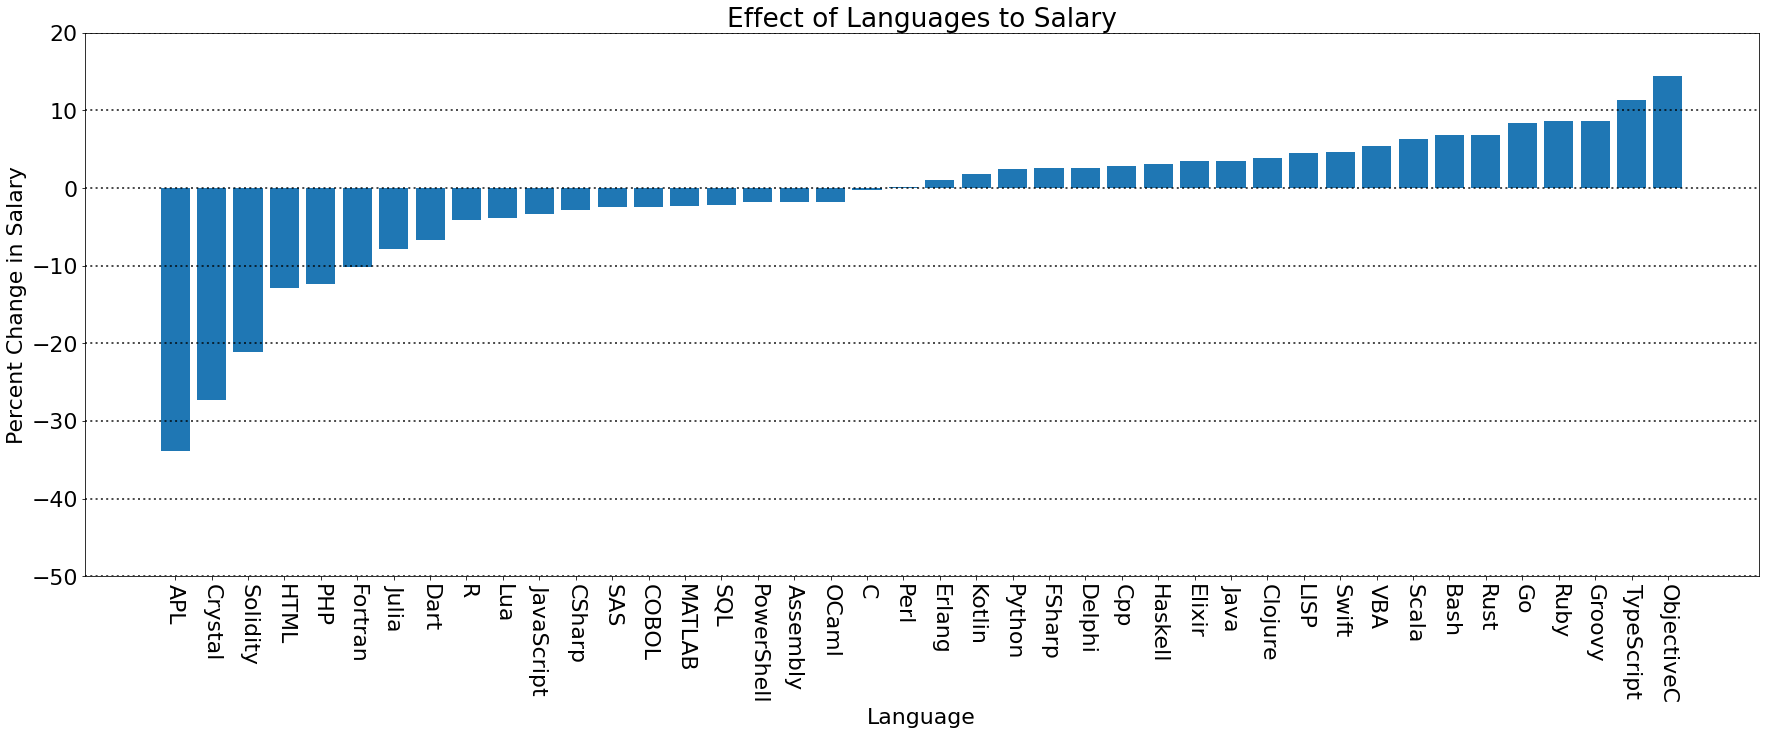

In [36]:
showCoefficientGraph(
  model_3,
  columns = cols(df_languages),
  y_scale_factor=100,
  font_size=22,
  title="Effect of Languages to Salary",
  xlabel="Language",
  ylabel="Percent Change in Salary"
).show()

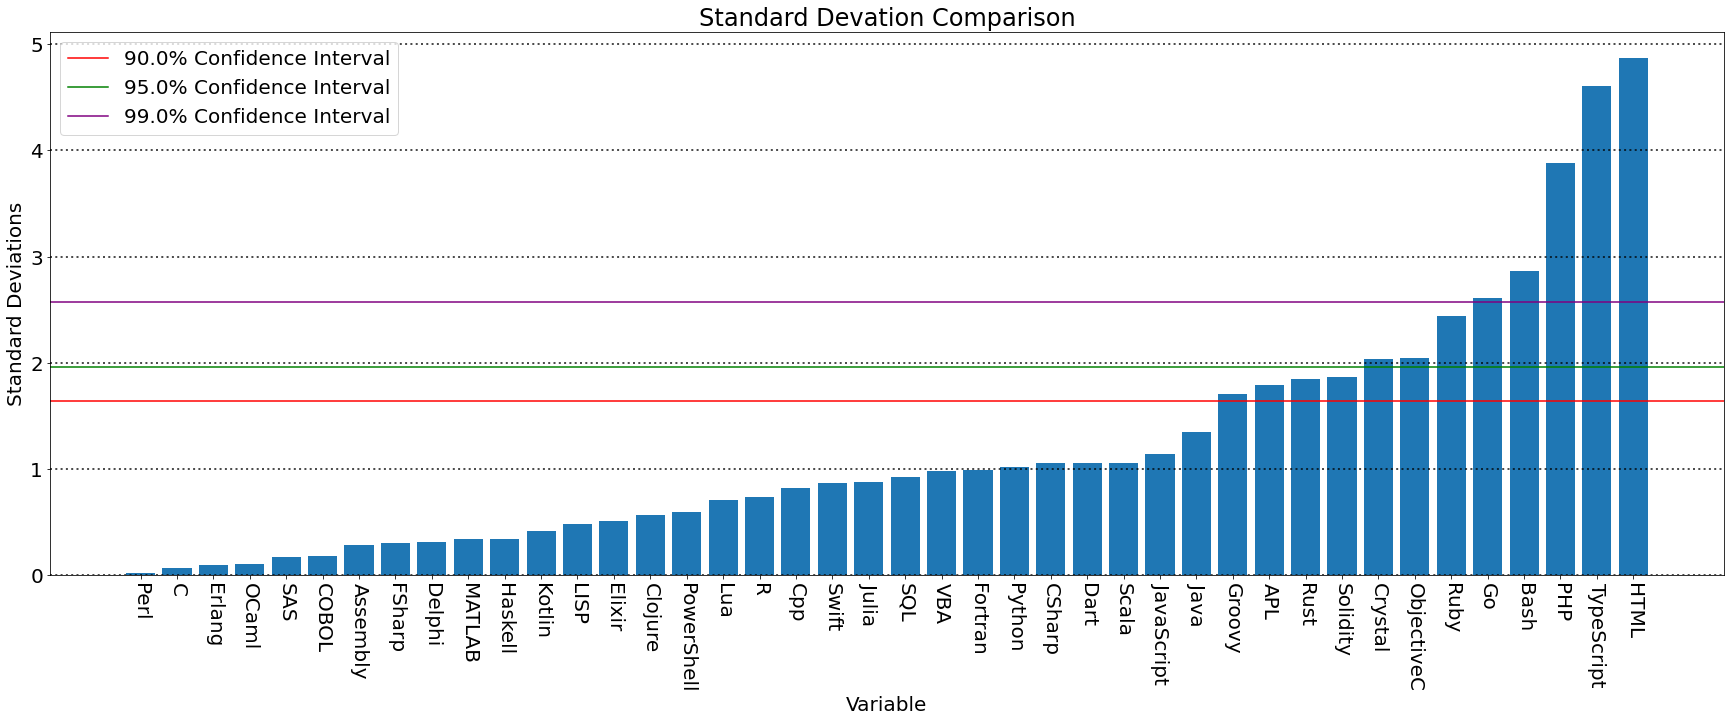

In [37]:
showCoefficientGraph(
  model_3,
  columns = cols(df_languages),
  scale=False,
  show_stddev=True,
  title="Standard Devation Comparison",
  ylabel="Standard Deviations",
  xlabel="Variable",
  font_size=20
).show()